# HAPT Recognition project

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import coverage_error, label_ranking_average_precision_score

X_train = np.loadtxt('HAPT Data Set/Train/X_train.txt', delimiter=' ')
Y_train = np.loadtxt('HAPT Data Set/Train/y_train.txt')

X_test = np.loadtxt('HAPT Data Set/Test/X_test.txt', delimiter=' ')
Y_test = np.loadtxt('HAPT Data Set/Test/y_test.txt')

print("The loading of the data is done.")

The loading of the data is done.


## Description of the data

In [5]:
print("The shape of the training data is ", X_train.shape, Y_train.shape)
print("The shape of the test data is ", X_test.shape, Y_test.shape)

The shape of the training data is  (7767, 561) (7767,)
The shape of the test data is  (3162, 561) (3162,)


We have 7767 samples decribed by 561 features in the training dataset while we have 3162 described by 561 features in the test dataset.

In [11]:
X_train_df = pd.DataFrame(X_train) # To transform the numpy array to a pandas DataFrame
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7767 entries, 0 to 7766
Columns: 561 entries, 0 to 560
dtypes: float64(561)
memory usage: 33.2 MB


We see that all the features are continuous. No need to perform pre-processing specific to categorical variables.

In [6]:
print("The labels are {} totaling a number of labels {}".format(np.unique(Y_train), len(np.unique(Y_train))))

The labels are [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.] totaling a number of labels 12


## Visualisation

Let us look at the labels' distribution, to see if a weighting is necessary.

(array([2299.,  987., 1293., 1423., 1413.,   47.,   23.,   75.,   60.,
         147.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

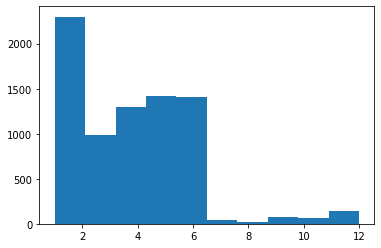

In [12]:
plt.hist(Y_train)

(array([967., 420., 508., 556., 545.,  23.,  10.,  32.,  25.,  76.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

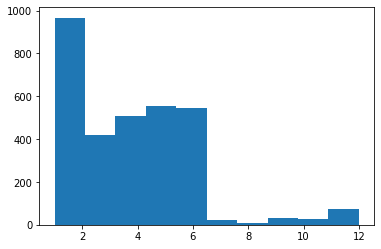

In [13]:
plt.hist(Y_test)

We notice that the test labels have the same distribution than the training labels which is a nice property for a dataset as the fitted model won't have to deal with a distribution drift.

## Machine Learning models

### 1 - Build the logistic regression

In [7]:
estimator = SGDClassifier(loss = 'log', penalty = 'elasticnet', random_state = 42)
param_grid = {'l1_ratio':[0,0.15,0.3,0.6,0.8,1],'alpha':[0.0001,0.001,0.01]}

clf = RandomizedSearchCV(estimator = estimator,param_distributions=param_grid,n_iter=5, cv=3)

clf.fit(X_train, Y_train)

best_model_LR, best_params_LR, best_score_LR = clf.best_estimator_, clf.best_params_, clf.best_score_

print(best_params_LR, best_score_LR)

{'l1_ratio': 0.3, 'alpha': 0.001} 0.9174713531608085


### 2 - Build the Random Forest Classifier

In [3]:
estimator = RandomForestClassifier(random_state = 42)
param_grid = {'n_estimators':[100,150,200],'criterion':['gini','entropy']}

clf = RandomizedSearchCV(estimator= estimator,param_distributions = param_grid, n_iter = 5, cv=3)

clf.fit(X_train, Y_train)

best_model_RF, best_params_RF, best_score_RF = clf.best_estimator_, clf.best_params_, clf.best_score_

print(best_params_RF, best_score_RF)

{'n_estimators': 200, 'criterion': 'entropy'} 0.9094888631389211


### 3 - Build the XGBClassifier

In [14]:
estimator = XGBClassifier(random_state = 42)
param_grid = {'max_depth':[3,4,5,7], 'n_estimators':[100,150,200,250],'colsample_bylevel':[0.7,0.8,0.9,1],
              'learning_rate':[0.01,0.03,0.05,0.1]}

clf = RandomizedSearchCV(estimator = estimator, param_distributions = param_grid,n_iter=5, cv=3)

clf.fit(X_train, Y_train)

best_model_XG, best_params_XG, best_score_XG = clf.best_estimator_, clf.best_params_, clf.best_score_

print(best_params_XG,best_score_XG)

{'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bylevel': 0.8} 0.9026651216685979


## Evaluation of the models

We need to one-hot-encode the labels in order to use the multilabel classification metrics : 

- The Label ranking average precision (LRAP) averages over the samples the answer to the following question: for each ground truth label, what fraction of higher-ranked labels were true labels? This performance measure will be higher if you are able to give better rank to the labels associated with each sample. The obtained score is always strictly greater than 0, and the best value is 1. If there is exactly one relevant label per sample, label ranking average precision is equivalent to the mean reciprocal rank.

In [15]:
def one_hot_encode_array(array, nb_labels):
    n = len(array)
    output = np.zeros((n, nb_labels))
    for idx in range(n):
        output[idx, int(array[idx])-1] = 1
    return output

In [16]:
Y_train_hot = one_hot_encode_array(Y_train, 12)
Y_test_hot = one_hot_encode_array(Y_test, 12)

pred_train_LR = best_model_LR.predict(X_train)
pred_test_LR = best_model_LR.predict(X_test)

pred_train_RF = best_model_RF.predict(X_train)
pred_test_RF = best_model_RF.predict(X_test)

pred_train_XG = best_model_XG.predict(X_train)
pred_test_XG = best_model_XG.predict(X_test)

pred_train_LR_hot = one_hot_encode_array(pred_train_LR, 12)
pred_test_LR_hot = one_hot_encode_array(pred_test_LR, 12)

pred_train_RF_hot = one_hot_encode_array(pred_train_RF, 12)
pred_test_RF_hot = one_hot_encode_array(pred_test_RF, 12)

pred_train_XG_hot = one_hot_encode_array(pred_train_XG, 12)
pred_test_XG_hot = one_hot_encode_array(pred_test_XG, 12)


print("Label ranking for train using LR", label_ranking_average_precision_score(Y_train_hot, pred_train_LR_hot))
print("Label ranking for test using LR", label_ranking_average_precision_score(Y_test_hot, pred_test_LR_hot))

print("Label ranking for train using RF", label_ranking_average_precision_score(Y_train_hot, pred_train_RF_hot))
print("Label ranking for test using RF", label_ranking_average_precision_score(Y_test_hot, pred_test_RF_hot))

print("Label ranking for train using XG", label_ranking_average_precision_score(Y_train_hot, pred_train_XG_hot))
print("Label ranking for test using XG", label_ranking_average_precision_score(Y_test_hot, pred_test_XG_hot))

Label ranking for train using LR 0.973917428436545
Label ranking for test using LR 0.938541007800971
Label ranking for train using RF 1.0
Label ranking for test using RF 0.9220166561248169
Label ranking for train using XG 1.0
Label ranking for test using XG 0.9249156651908077


## Standardisation des variables predictives

In [17]:
def standardise(array):
    return (array - np.mean(array, axis=0)) / np.std(array, axis=0)

X_train_standard = standardise(X_train)
X_test_standard = standardise(X_test)

In [18]:
#SGD

estimator = SGDClassifier(loss = 'log', penalty = 'elasticnet', random_state = 42)
param_grid = {'l1_ratio':[0,0.15,0.3,0.6,0.8,1],'alpha':[0.0001,0.001,0.01]}

clf = RandomizedSearchCV(estimator = estimator,param_distributions=param_grid,n_iter=5, cv=3)

clf.fit(X_train_standard, Y_train)

best_model_LR_std, best_params_LR_std, best_score_LR_std = clf.best_estimator_, clf.best_params_, clf.best_score_

print(best_params_LR_std, best_score_LR_std)

#RF

estimator = RandomForestClassifier(random_state = 42)
param_grid = {'n_estimators':[100,150,200],'criterion':['gini','entropy']}

clf = RandomizedSearchCV(estimator= estimator,param_distributions = param_grid, n_iter = 5, cv=3)

clf.fit(X_train_standard, Y_train)

best_model_RF_std, best_params_RF_std, best_score_RF_std = clf.best_estimator_, clf.best_params_, clf.best_score_

print(best_params_RF_std, best_score_RF_std)

#XG

estimator = XGBClassifier(random_state = 42)
param_grid = {'max_depth':[3,4,5,7], 'n_estimators':[100,120,150],'colsample_bylevel':[0.7,0.8,0.9,1],
              'learning_rate':[0.01,0.03,0.05,0.1]}

clf = RandomizedSearchCV(estimator = estimator, param_distributions = param_grid,n_iter=2, cv=3)

clf.fit(X_train_standard, Y_train)

best_model_XG_std, best_params_XG_std, best_score_XG_std = clf.best_estimator_, clf.best_params_, clf.best_score_

print(best_params_XG_std,best_score_XG_std)

{'l1_ratio': 0.3, 'alpha': 0.001} 0.9125788592764259
{'n_estimators': 200, 'criterion': 'entropy'} 0.9093601132998583
{'n_estimators': 120, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bylevel': 1} 0.8958413801982748


In [19]:
pred_train_LR_std = best_model_LR_std.predict(X_train_standard)
pred_test_LR_std = best_model_LR_std.predict(X_test_standard)

pred_train_RF_std = best_model_RF_std.predict(X_train_standard)
pred_test_RF_std = best_model_RF_std.predict(X_test_standard)

pred_train_XG_std = best_model_XG_std.predict(X_train_standard)
pred_test_XG_std = best_model_XG_std.predict(X_test_standard)

pred_train_LR_std_hot = one_hot_encode_array(pred_train_LR_std, 12)
pred_test_LR_std_hot = one_hot_encode_array(pred_test_LR_std, 12)

pred_train_RF_std_hot = one_hot_encode_array(pred_train_RF_std, 12)
pred_test_RF_std_hot = one_hot_encode_array(pred_test_RF_std, 12)

pred_train_XG_std_hot = one_hot_encode_array(pred_train_XG_std, 12)
pred_test_XG_std_hot = one_hot_encode_array(pred_test_XG_std, 12)


print("Label ranking for train using LR", label_ranking_average_precision_score(Y_train_hot, pred_train_LR_std_hot))
print("Label ranking for test using LR", label_ranking_average_precision_score(Y_test_hot, pred_test_LR_std_hot))

print("Label ranking for train using RF", label_ranking_average_precision_score(Y_train_hot, pred_train_RF_std_hot))
print("Label ranking for test using RF", label_ranking_average_precision_score(Y_test_hot, pred_test_RF_std_hot))

print("Label ranking for train using XG", label_ranking_average_precision_score(Y_train_hot, pred_train_XG_std_hot))
print("Label ranking for test using XG", label_ranking_average_precision_score(Y_test_hot, pred_test_XG_std_hot))

Label ranking for train using LR 0.9753336766662349
Label ranking for test using LR 0.9272348724436014
Label ranking for train using RF 1.0
Label ranking for test using RF 0.9144792325532388
Label ranking for train using XG 1.0
Label ranking for test using XG 0.9179580434324285


## Reduction de la dimension

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

pca.fit(X_train_standard)

X_train_pca = pca.transform(X_train_standard)
X_test_pca = pca.transform(X_test_standard)

In [21]:
#SGD

estimator = SGDClassifier(loss = 'log', penalty = 'elasticnet', random_state = 42)
param_grid = {'l1_ratio':[0,0.15,0.3,0.6,0.8,1],'alpha':[0.0001,0.001,0.01]}

clf = RandomizedSearchCV(estimator = estimator,param_distributions=param_grid,n_iter=5, cv=3)

clf.fit(X_train_pca, Y_train)

best_model_LR_pca, best_params_LR_pca, best_score_LR_pca = clf.best_estimator_, clf.best_params_, clf.best_score_

print(best_params_LR_pca, best_score_LR_pca)

#RF

estimator = RandomForestClassifier(random_state = 42)
param_grid = {'n_estimators':[100,150,200],'criterion':['gini','entropy']}

clf = RandomizedSearchCV(estimator= estimator,param_distributions = param_grid, n_iter = 5, cv=3)

clf.fit(X_train_pca, Y_train)

best_model_RF_pca, best_params_RF_pca, best_score_RF_pca = clf.best_estimator_, clf.best_params_, clf.best_score_

print(best_params_RF_pca, best_score_RF_pca)

#XG

estimator = XGBClassifier(random_state = 42)
param_grid = {'max_depth':[3,4,5,7], 'n_estimators':[100,150,200,250],'colsample_bylevel':[0.7,0.8,0.9,1],
              'learning_rate':[0.01,0.03,0.05,0.1]}

clf = RandomizedSearchCV(estimator = estimator, param_distributions = param_grid,n_iter=5, cv=3)

clf.fit(X_train_pca, Y_train)

best_model_XG_pca, best_params_XG_pca, best_score_XG_pca = clf.best_estimator_, clf.best_params_, clf.best_score_

print(best_params_XG_pca,best_score_XG_pca)

{'l1_ratio': 0.6, 'alpha': 0.0001} 0.8424101969872537
{'n_estimators': 150, 'criterion': 'gini'} 0.8179477275653405
{'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bylevel': 1} 0.8227114716106605


In [22]:
pred_train_LR_pca = best_model_LR_pca.predict(X_train_pca)
pred_test_LR_pca = best_model_LR_pca.predict(X_test_pca)

pred_train_RF_pca = best_model_RF_pca.predict(X_train_pca)
pred_test_RF_pca = best_model_RF_pca.predict(X_test_pca)

pred_train_XG_pca = best_model_XG_pca.predict(X_train_pca)
pred_test_XG_pca = best_model_XG_pca.predict(X_test_pca)

pred_train_LR_pca_hot = one_hot_encode_array(pred_train_LR_pca, 12)
pred_test_LR_pca_hot = one_hot_encode_array(pred_test_LR_pca, 12)

pred_train_RF_pca_hot = one_hot_encode_array(pred_train_RF_pca, 12)
pred_test_RF_pca_hot = one_hot_encode_array(pred_test_RF_pca, 12)

pred_train_XG_pca_hot = one_hot_encode_array(pred_train_XG_pca, 12)
pred_test_XG_pca_hot = one_hot_encode_array(pred_test_XG_pca, 12)


print("Label ranking for train using LR", label_ranking_average_precision_score(Y_train_hot, pred_train_LR_pca_hot))
print("Label ranking for test using LR", label_ranking_average_precision_score(Y_test_hot, pred_test_LR_pca_hot))

print("Label ranking for train using RF", label_ranking_average_precision_score(Y_train_hot, pred_train_RF_pca_hot))
print("Label ranking for test using RF", label_ranking_average_precision_score(Y_test_hot, pred_test_RF_pca_hot))

print("Label ranking for train using XG", label_ranking_average_precision_score(Y_train_hot, pred_train_XG_pca_hot))
print("Label ranking for test using XG", label_ranking_average_precision_score(Y_test_hot, pred_test_XG_pca_hot))

Label ranking for train using LR 0.8911849276855013
Label ranking for test using LR 0.8651960784313745
Label ranking for train using RF 1.0
Label ranking for test using RF 0.8515707358212139
Label ranking for train using XG 0.9759237800952725
Label ranking for test using XG 0.8579485557663964


## Choix du meilleur modele

Le meilleur modele est : la logistique regression appliquee sur les donnees sans standardisation ni reduction de la dimension.

## API Django